In [1]:
import numpy as np
from random import random
from tqdm import tqdm
import ray
ray.init()

2020-11-10 21:27:18,435	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.140.16',
 'raylet_ip_address': '192.168.140.16',
 'redis_address': '192.168.140.16:6379',
 'object_store_address': '/tmp/ray/session_2020-11-10_21-27-17_737956_1583993/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-10_21-27-17_737956_1583993/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-11-10_21-27-17_737956_1583993',
 'metrics_export_port': 38746,
 'node_id': '4e15429ab7d37dc46f499f1a08ee349c13a38e70'}

Want to sample from three variables:
1. $\lambda$
2. $\tau$
3. $\beta$

-> these values are then averaged to get the Monte-Carlo estimator
-> first: what is density of $\beta$?

In [2]:
# import data from DNN training
extracted_coefficients_directory = '../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)

theta_prior = 2.5

In [3]:
beta = np.repeat(0,10)
# number of samples we want to produce
M = 10000 + 1
L = 20

# number of parameters of theta
q = 2*B_zeta.shape[1] + 1
p = B_zeta.shape[1]

n = B_zeta.shape[0]

# start values for beta, lambda, tau
# beta is taken from trained network and other two
# are initialized randomly
theta_m_1 = np.zeros(q)

# stepsize
epsilon = 0.00001

r_m = np.zeros(theta_m_1.shape[0])

tau_start = theta_m_1[q-1]

In [4]:
Lambda = np.repeat(1,p)
BoB = B_zeta**2

In [5]:
@ray.remote
def delta_beta(z, S, B_zeta, Lambda, beta):
    return ((z*(1/S).T).dot(B_zeta) - (beta.T).dot(B_zeta.T).dot(B_zeta) + np.sum(((1/Lambda)**2)*beta))
@ray.remote
def delta_1_log_tau(p, log_tau, Lambda):
    tau = np.exp(log_tau)
    tau2 = tau**2
    Lambda2 = Lambda**2
    return(- (p-1) - (2*tau2)/(1+tau2) + 2*np.sum((Lambda2/tau2)/(1+Lambda2/(tau2))))

def generate_dS2_ddS2_S2_S(Lambda, BoB):
    
    n, p = BoB.shape
    W = np.sum(BoB*(Lambda**2), axis = 1)
    S2 = (1/(1 + W))
    S = np.sqrt(S2)
    
    dS2, ddS2 = np.zeros((n,p)), np.zeros((n,p))
    for lj in range(0, p):
        dS2[:,lj] = - BoB[:,lj]*(Lambda[lj]**2)/((1+W)**2)
        ddS2[:,lj] = (-BoB[:,lj]*(Lambda[lj]**2) + (BoB[:,lj]*(Lambda[lj]**2)**2))/((1+W)**3)
    
    return(dS2, ddS2, S2, S)

@ray.remote
def delta_1_lambda(Lambda, beta, B_zeta, dS2, ddS2, S2, S, z, tau):
    p = len(Lambda)
    Lambda2 = Lambda**2
    tau2 = tau**2
    dlogFucj = np.zeros(p)
    #for lj in tqdm(range(0,p)):
    #    dlogFucj[lj] = 0.5*(beta[lj]**2)/Lambda2[lj] - (Lambda2[lj]/tau2)/(1 + Lambda2[lj]/tau2) - 0.5*np.sum(dS2[:,lj]/S2) - 0.5*np.sum((z*z*(-dS2[:,lj]/(S2**2)))) + np.sum( beta.dot(B_zeta.T).dot(np.diag(-0.5*(dS2[:,lj]/(S2**(1.5))))).dot(z))  
    dlogFucj = (0.5*(beta**2)/Lambda2 - (Lambda2/tau2)/(1 + Lambda2/tau2) - 0.5*np.sum(dS2/(np.tile(S2.T, [p,1]).T), axis = 0) - 
               0.5*np.sum((np.tile(z*z, [p,1]).T*(-dS2/np.tile((S2**2), [p,1]).T)), axis = 0) + 
               (beta*((B_zeta*(-0.5)*(dS2/np.tile(S2**1.5, [p,1]).T)).T).dot(z)))
    return(dlogFucj)

def Delta_theta(vartheta_t, B, n, z, p, tBB, betaBt, BoB):
    vartheta_new = vartheta_t.copy()
    beta_t = vartheta_new[0:p].reshape(p,)
    Lambda_t = vartheta_new[p:2*p]
    log_tau_t = vartheta_new[2*p]

    dS2, ddS2, S2, S = generate_dS2_ddS2_S2_S(Lambda_t, BoB)
    
    # Gradient w.r.t. beta
    #grad_beta = delta_beta(z, S, B, Lambda_t, beta)
    
    #grad_lambda = delta_1_lambda(Lambda_t, beta_t, B, dS2, ddS2, S2, S, z, np.exp(log_tau_t))
    # Gradient w.r.t. tau
    #grad_tau = delta_1_log_tau(p, log_tau_t, Lambda_t)
    
    ret_id1 = delta_beta.remote(z, S, B, Lambda_t, beta)
    ret_id2 = delta_1_lambda.remote(Lambda_t, beta_t, B, dS2, ddS2, S2, S, z, np.exp(log_tau_t))
    ret_id3 = delta_1_log_tau.remote(p, log_tau_t, Lambda_t)
    grad_beta, grad_lambda, grad_tau = ray.get([ret_id1, ret_id2, ret_id3])
    #print(grad_beta, grad_lambda, grad_tau)
    
    return(np.append(grad_beta, np.append(grad_lambda, grad_tau)))

def log_density(z, u,  beta, B, p,  n, S, S2, tBB, theta, betaBt):   
    return (- 0.5*np.sum(np.log(S2))- 0.5*z.dot((1/S2)*z)+ 
            betaBt.dot(z*(1/S)) - 
            0.5*beta.T.dot(tBB).dot(beta) - 
            0.5/np.exp(u)*np.sum(beta**2) - 
            0.5*u*(p-1)  - np.sqrt(np.exp(u)/theta))



In [6]:
def Leapfrog(theta, r, epsilon, n, z, p, B, tBB, betaBt):
    
    # compute gradient with theta
    Delta_theta_t = Delta_theta(theta, B, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde = r + (epsilon/2)*Delta_theta_t

    # update theta
    theta_tilde = (theta + epsilon*r_tilde).reshape(2*p + 1,)
    beta_t = theta_tilde[0:p]
    betaBt_t = beta_t.dot(B_zeta.T)
    
    # compute updated gradient
    Delta_theta_tilde = Delta_theta(theta_tilde, B, n, z, p, tBB, betaBt_t, BoB)
    
    # update momentum again
    r_tilde = r_tilde + (epsilon/2)*Delta_theta_tilde
    
    return(theta_tilde, r_tilde)

In [7]:
r0 = np.repeat(None, M)
theta_tilde = np.repeat(None, M)
r_tilde = np.repeat(None, M)
log_dens =  np.repeat(None, M)
alpha = np.repeat(None, M)
theta_m_1 = np.repeat(None, M)
r_m = np.repeat(None, M)
theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(1,p), 0))

acc = []
# loop over number of samples that we want to produce
theta_tilde[0] = np.append(np.zeros(p), np.append(np.repeat(1,p), 0))
r_tilde[0] = np.zeros(q)
theta_m_1[1] = np.append(np.zeros(p), np.append(np.repeat(1,p), 0))
all_thetas = []
theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(1,p), 0))
for m in tqdm(range(1, M)):
    
    # Update S
    # draw momentum from normal distribution
    r0[m] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
    
    # set new parameters
    theta_tilde[m] = theta_m_1[m].reshape(q,)
    r_tilde[m] = r0[m]
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # generate proposal through L leapfrog updates 
    for i in range(0,L):
        betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
        theta_tilde[m], r_tilde[m] = Leapfrog(theta_tilde[m], 
                                              r_tilde[m], 
                                              epsilon, n, z, p, 
                                              B_zeta, tBB, 
                                              betaBt)
    
    dS2, ddS2, S2, S = generate_dS2_ddS2_S2_S(theta_tilde[m][p:2*p], BoB)
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # probability that proposal is accepted
    log_dens[m] = log_density(z, theta_tilde[m][p],  theta_tilde[m][0:p], B_zeta, p,  n, S, S2, tBB, theta_prior, betaBt)
    alpha[m] = min([1, (np.exp(log_dens[m] - r_tilde[m].dot(r_tilde[m].T)*1/2))/np.exp((log_dens[m] - r0[m].dot(r0[m].T)*1/2))])
    
    decision = np.random.uniform(0,1,1)
    if decision <= alpha[m]:
        theta_m_1[m + 1] = theta_tilde[m]
        r_m[m + 1] = - r_tilde[m]
        acc.append(1)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    else:
        theta_m_1[m + 1] = theta_tilde[m - 1]
        r_m[m + 1] = - r_tilde[m - 1]
        acc.append(0)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-7-378e8916f17b>:42: RuntimeWarning: invalid value encountered in true_divide
  alpha[m] = min([1, (np.exp(log_dens[m] - r_tilde[m].dot(r_tilde[m].T)*1/2))/np.exp((log_dens[m] - r0[m].dot(r0[m].T)*1/2))])
  1%|          | 57/10000 [11:53<34:33:30, 12.51s/it]


KeyboardInterrupt: 

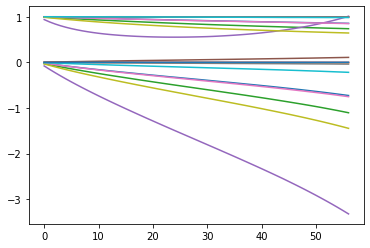

In [8]:
import matplotlib.pyplot as plt
plt.plot(all_thetas)

In [9]:
df = np.array(all_thetas)

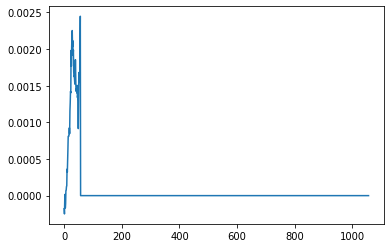

In [33]:
plt.plot(np.append(df[:,20],np.repeat(0,1000)))

In [ ]:
all_thetas[93][10:21]

In [ ]:
theta_hmc = np.mean(all_thetas, axis = 0)
np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/all_thetas.npy', np.array(all_taus[J[1]:]))

In [ ]:
theta_hmc

In [ ]:
# comparison with VA

In [ ]:
vartheta_va = np.genfromtxt('../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/vartheta.csv', delimiter=",")

In [ ]:
theta_va = np.mean(vartheta_va[int(0.9*50000):50000, :], axis = 0)

In [ ]:
0.9*50000

In [ ]:
plt.scatter(theta_hmc[0:10], theta_va[0:10])

In [ ]:
beta_va = theta_hmc[0:10]

In [ ]:
beta_va.shape